## Importar librerias y modulos

In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

## Extracción de datasets

In [58]:
df_generacion = pd.read_csv('../data/Generacion.csv')
df_demanda = pd.read_csv('../data/Demanda.csv')
df_capacidad =pd.read_csv('../data/Capacidad.csv')

Visualización de datos crudos

In [59]:
df_generacion = df_generacion[['Fecha','GeneracionRealEstimada']]
df_generacion.head()

,Fecha,GeneracionRealEstimada
0,2019-12-30,301801.06
1,2019-12-30,0.00
2,2019-12-30,41952.37
3,2019-12-30,54232.03
4,2019-12-30,44690.88


In [60]:
df_capacidad.head()


,Fecha,Capacidad acumulada [MW]
0,2022-01-01,17263.262
1,2022-01-02,17263.262
2,2022-01-03,17263.262
3,2022-01-04,17263.262
4,2022-01-05,17263.262


In [61]:
df_demanda.head()

,FechaHora,Valor
0,2023-06-01T23:00:00,5106.44
1,2023-06-01T22:00:00,5106.82
2,2023-06-01T21:00:00,5104.55
3,2023-06-01T20:00:00,5095.07
4,2023-06-01T19:00:00,5096.44


## Funciones

In [62]:
def transformar_dataset(df, col_fecha, col_valor, unidad_origen):
    # Convertir fecha al formato AAAA-MM-DD
    df = df.copy()
    df[col_fecha] = pd.to_datetime(df[col_fecha]).dt.strftime('%Y-%m-%d')
    df.rename(columns={col_fecha: 'Fecha', col_valor: 'Valor'}, inplace=True)
    
    # Convertir a GWh según la unidad de origen
    if unidad_origen.lower() == 'kwh':
        df['Valor'] = df['Valor'] / 1e6
    elif unidad_origen.lower() == 'mwh':
        df['Valor'] = df['Valor'] / 1e3
    # Si ya está en GWh, no se transforma
    
    # Tomar solo columnas requeridas
    df = df[['Fecha', 'Valor']]
    return df

def sumar_diario(df):
    df_grouped = df.groupby('Fecha', as_index=False)['Valor'].sum()
    return df_grouped

## Modelo de prophet

from prophet.diagnostics import cross_validation, performance_metrics

def entrenar_predecir_validar_prophet(df_diario, nombre_variable, fecha_final="2025-10-31"):
    # Preparación y ajuste del modelo (como antes)
    df_prophet = df_diario.rename(columns={'Fecha': 'ds', 'Valor': 'y'})
    df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
    df_prophet = df_prophet[df_prophet['ds'] <= fecha_final]
    
    def obtener_festivos_colombia(year):
        return pd.DataFrame({
            'holiday': 'colombia_holiday',
            'ds': [pd.to_datetime(f'{year}-01-01'), pd.to_datetime(f'{year}-07-20'), pd.to_datetime(f'{year}-12-25')],
            'lower_window': 0,
            'upper_window': 1
        })
    años = range(df_prophet['ds'].min().year, pd.to_datetime(fecha_final).year + 1)
    festivos_df = pd.concat([obtener_festivos_colombia(a) for a in años]
                            ).drop_duplicates(subset=['ds']).reset_index(drop=True)

    modelo = Prophet(
        holidays=festivos_df,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode='multiplicative'
    )
    modelo.fit(df_prophet)
    
    # Cross-validation Prophet
    df_cv = cross_validation(
        modelo, 
        initial='730 days',
        period='180 days',
        horizon = '365 days'
    )
    df_p = performance_metrics(df_cv)
    print(f"\n--- {nombre_variable}: Métricas con Validación Cruzada ---")
    print(df_p[['horizon', 'mae', 'rmse', 'mape', 'smape']].groupby('horizon').mean())

    if 'y' in df_cv and 'yhat' in df_cv:
        r2 = r2_score(df_cv['y'], df_cv['yhat'])
        print(f'R2 global (manual, cross-validation): {r2:.4f}')

    # Predicción extendida hasta 2030 (como antes)
    fecha_fin_pred = pd.to_datetime("2030-12-31")
    dias_futuros = (fecha_fin_pred - df_prophet['ds'].max()).days
    future = modelo.make_future_dataframe(periods=dias_futuros)
    forecast = modelo.predict(future)

    # Comparación real vs. predicción y gráfico (como antes)
    df_pred = pd.merge(df_prophet, forecast[['ds', 'yhat']], on='ds', how='inner')
    plt.figure(figsize=(14,6))
    plt.plot(df_prophet['ds'], df_prophet['y'], label=f'{nombre_variable} Real')
    plt.plot(forecast['ds'], forecast['yhat'], label=f'Predicción Prophet ({nombre_variable})')
    plt.axvline(pd.to_datetime(fecha_final), color='k', linestyle='--', alpha=0.5, label='Fin datos reales')
    plt.title(f'{nombre_variable}: Real vs Predicho (con Validación Cruzada)')
    plt.xlabel('Fecha')
    plt.ylabel('GWh diarios')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return modelo, forecast, df_cv, df_p

## Transofrmacion de dataset a Fecha | Valor (GwH)

In [63]:
df_generacion_std = transformar_dataset(df_generacion, 'Fecha', 'GeneracionRealEstimada', 'kwh')
df_capacidad_std = transformar_dataset(df_capacidad, 'Fecha', 'Capacidad acumulada [MW]', 'mwh')
df_demanda_std = transformar_dataset(df_demanda, 'FechaHora', 'Valor', 'kwh')


In [64]:
df_generacion_diario = sumar_diario(df_generacion_std)
df_capacidad_diario = sumar_diario(df_capacidad_std)
df_demanda_diario = sumar_diario(df_demanda_std)

In [65]:
df_demanda_diario.describe()

,Valor
count,1405.000000
mean,241.386277
std,92.859699
min,161.861127
25%,208.021360
50%,217.682285
75%,228.949085
max,719.300480


In [70]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


## EDA

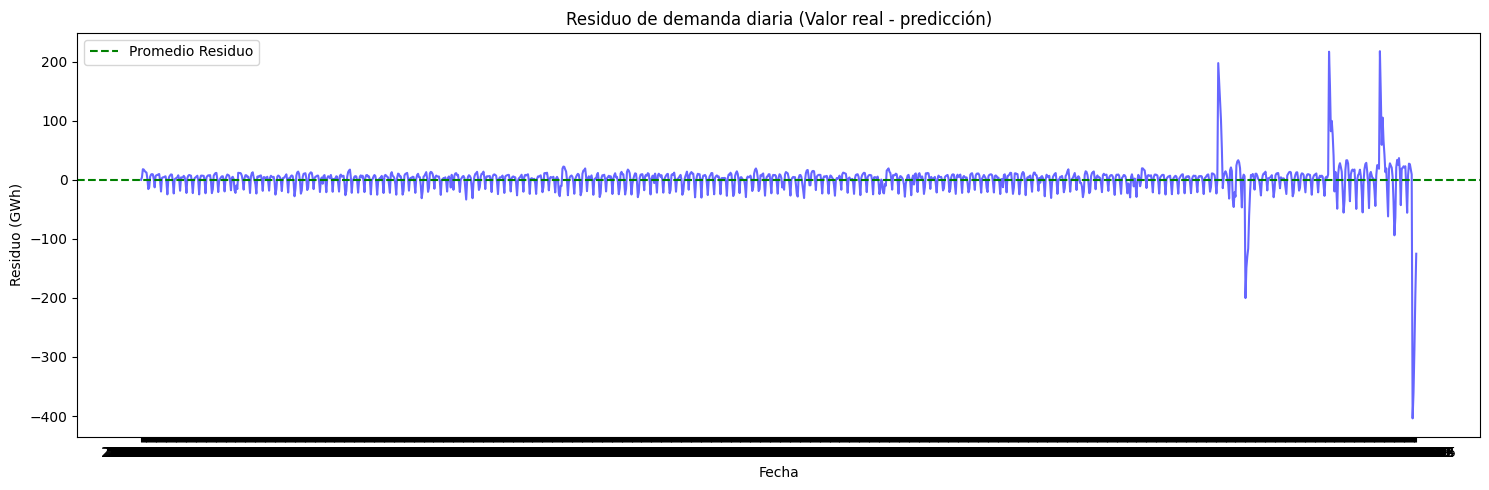

In [73]:
# Supongamos df_pred tiene las columnas ['Fecha', 'Valor', 'Prediccion']
df_pred = df_demanda_diario.copy()
# Simulación de predicción para ejemplificar
df_pred['Prediccion'] = df_pred['Valor'].rolling(7, min_periods=1).mean()
df_pred['Residuo'] = df_pred['Valor'] - df_pred['Prediccion']

plt.figure(figsize=(15,5))
plt.plot(df_pred['Fecha'], df_pred['Residuo'], color='blue', alpha=0.6)
plt.axhline(df_pred['Residuo'].mean(), color='green', linestyle='--', label='Promedio Residuo')
plt.title('Residuo de demanda diaria (Valor real - predicción)')
plt.xlabel('Fecha')
plt.ylabel('Residuo (GWh)')
plt.legend()
plt.tight_layout()
plt.show()



## codigo para investigar las fechas con outlier

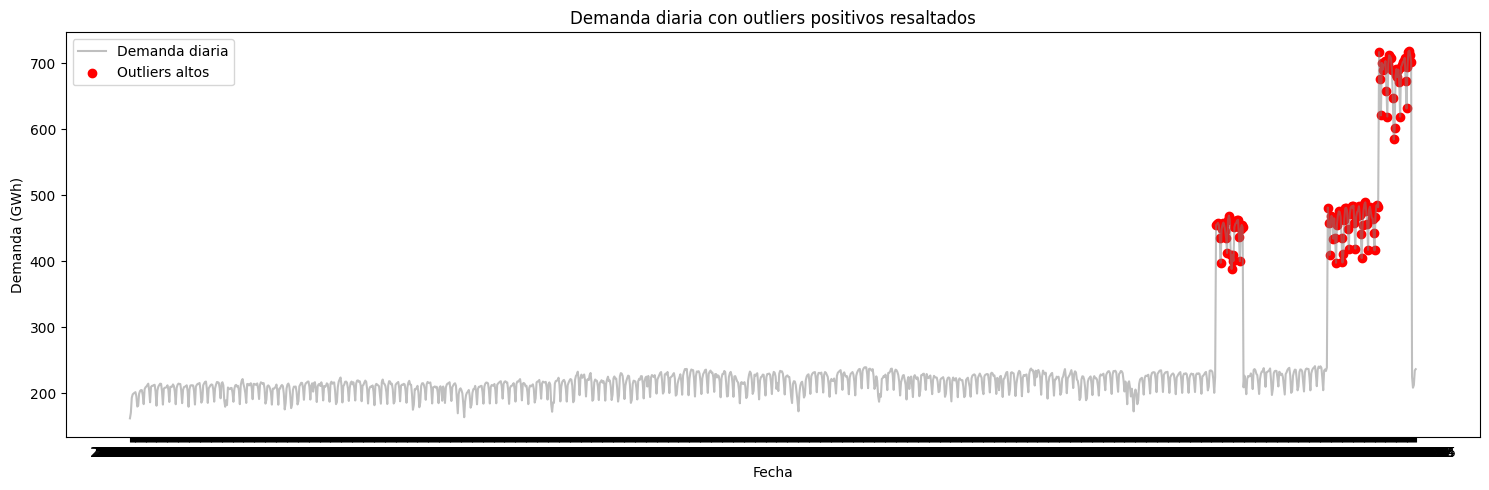

In [75]:

# Definición de los límites de outliers (como en el ejemplo anterior)
Q1 = df_demanda_diario['Valor'].quantile(0.25)
Q3 = df_demanda_diario['Valor'].quantile(0.75)
IQR = Q3 - Q1
upper_thresh = Q3 + 1.5 * IQR

# Selección de outliers positivos extremos
outliers_altos = df_demanda_diario[df_demanda_diario['Valor'] > upper_thresh]

# Guardar en archivo CSV
outliers_altos[['Fecha', 'Valor']].to_csv('outliers_demanda_altos.csv', index=False)

# Graficar la serie completa y resaltar los outliers
plt.figure(figsize=(15,5))
plt.plot(df_demanda_diario['Fecha'], df_demanda_diario['Valor'], color='gray', alpha=0.5, label='Demanda diaria')
plt.scatter(outliers_altos['Fecha'], outliers_altos['Valor'], color='red', label='Outliers altos')
plt.title('Demanda diaria con outliers positivos resaltados')
plt.xlabel('Fecha')
plt.ylabel('Demanda (GWh)')
plt.legend()
plt.tight_layout()
plt.show()



## limpieza de outliers del dataframe demanda

In [78]:
# Supone que df_demanda_diario tiene las columnas 'Fecha' y 'Valor'
media_valor = df_demanda_diario['Valor'].mean()

# Definición de multiplicador para extremos (ejemplo: mayor a 2.5 veces la media)
multiplo_extremo = 1.3 
umbral_extremo = media_valor * multiplo_extremo

# Detección de extremos (esto puede ajustarse; aquí, varios múltiplos sobre la media)
extremos_mask = df_demanda_diario['Valor'] > umbral_extremo

# Crear copia para transformaciones
df_demanda_limpio = df_demanda_diario.copy()

# Reemplazar valores extremos por la media diaria
df_demanda_limpio.loc[extremos_mask, 'Valor'] = media_valor

# Guardar los valores modificados para auditoría
#df_extremos_cambiados = df_demanda_diario.loc[extremos_mask]
#df_extremos_cambiados[['Fecha', 'Valor']].to_csv('outliers_extremos_cambiados.csv', index=False)

# Guardar el nuevo dataset limpio para modelar
#df_demanda_limpio.to_csv('demanda_diaria_limpia.csv', index=False)

print(f"Outliers extremos eliminados/reemplazados ({extremos_mask.sum()} días).")
print("Dataset listo para modelar guardado como 'demanda_diaria_limpia.csv'.")
print("Fechas y valores de extremos reemplazados guardadas en 'outliers_extremos_cambiados.csv'.")

Outliers extremos eliminados/reemplazados (122 días).
Dataset listo para modelar guardado como 'demanda_diaria_limpia.csv'.
Fechas y valores de extremos reemplazados guardadas en 'outliers_extremos_cambiados.csv'.


## Modelo para demanda y generación

12:09:28 - cmdstanpy - INFO - Chain [1] start processing
12:09:28 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/2 [00:00<?, ?it/s]12:09:28 - cmdstanpy - INFO - Chain [1] start processing
12:09:28 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  6.05it/s]12:09:28 - cmdstanpy - INFO - Chain [1] start processing
12:09:28 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  5.60it/s]



--- Demanda: Métricas con Validación Cruzada ---
                mae       rmse      mape     smape
horizon                                           
37 days    5.330450   7.266758  0.025054  0.024543
38 days    5.325302   7.284942  0.024997  0.024484
39 days    5.405481   7.341323  0.025314  0.024811
40 days    5.264860   7.103303  0.024542  0.024092
41 days    5.090618   6.800791  0.023643  0.023251
...             ...        ...       ...       ...
361 days  17.923876  21.359385  0.074285  0.078480
362 days  18.074745  21.327684  0.075134  0.079131
363 days  18.174108  21.350253  0.075575  0.079562
364 days  18.384125  21.440822  0.076529  0.080515
365 days  18.538589  21.507273  0.077249  0.081247

[329 rows x 4 columns]
R2 global (manual, cross-validation): 0.2162


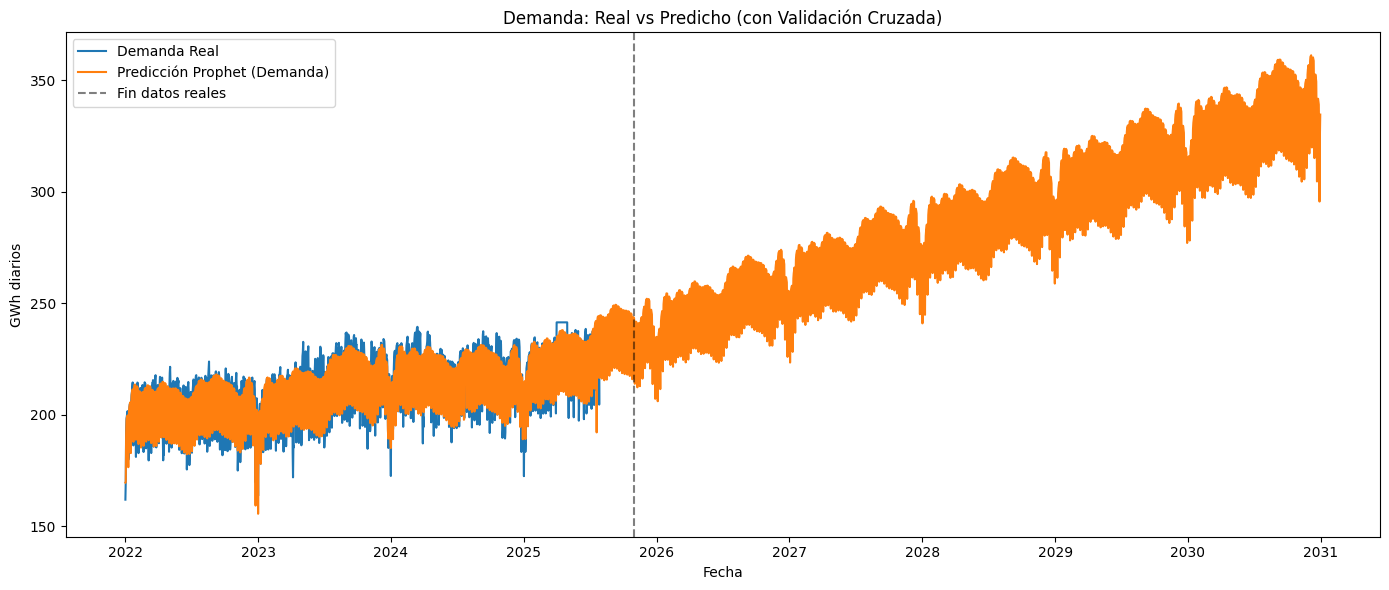

12:09:29 - cmdstanpy - INFO - Chain [1] start processing
12:09:30 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/20 [00:00<?, ?it/s]12:09:30 - cmdstanpy - INFO - Chain [1] start processing
12:09:30 - cmdstanpy - INFO - Chain [1] done processing
  5%|▌         | 1/20 [00:00<00:03,  6.29it/s]12:09:30 - cmdstanpy - INFO - Chain [1] start processing
12:09:30 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 2/20 [00:00<00:03,  5.31it/s]12:09:30 - cmdstanpy - INFO - Chain [1] start processing
12:09:30 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▌        | 3/20 [00:00<00:03,  4.91it/s]12:09:30 - cmdstanpy - INFO - Chain [1] start processing
12:09:30 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 4/20 [00:00<00:03,  4.76it/s]12:09:31 - cmdstanpy - INFO - Chain [1] start processing
12:09:31 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 5/20 [00:01<00:03,  4.47it/s]12:09:31 - cmdstanpy - INFO - Chain [1] start processi


--- Generación: Métricas con Validación Cruzada ---
                mae       rmse      mape     smape
horizon                                           
37 days    6.222199   8.429080  0.032117  0.031870
38 days    6.199228   8.393871  0.032041  0.031824
39 days    6.193116   8.387033  0.032004  0.031790
40 days    6.246485   8.446488  0.032288  0.032063
41 days    6.294525   8.474217  0.032564  0.032327
...             ...        ...       ...       ...
361 days  11.391716  14.418672  0.057897  0.057828
362 days  11.403543  14.423506  0.058036  0.057945
363 days  11.370528  14.367563  0.057895  0.057796
364 days  11.345176  14.310713  0.057815  0.057703
365 days  11.359336  14.345771  0.057941  0.057795

[329 rows x 4 columns]
R2 global (manual, cross-validation): 0.7655


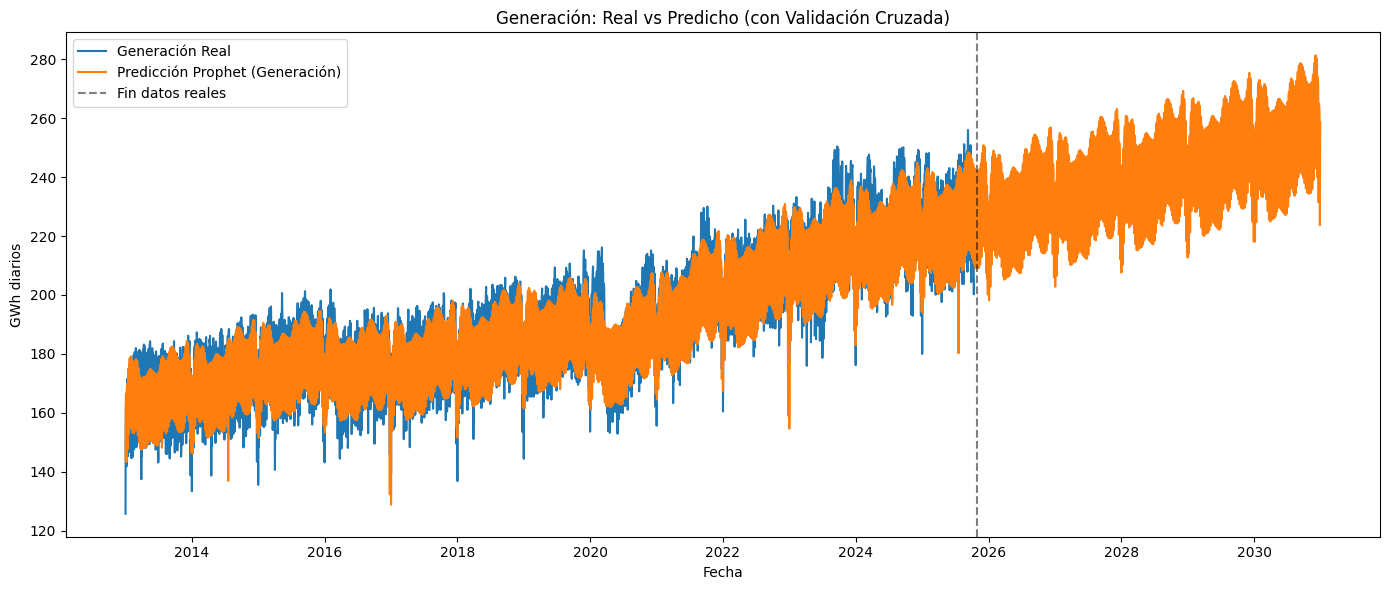

In [79]:
# Ejemplo de uso (para demanda y generación)
# Ejemplo de uso con Demanda
modelo_demanda, forecast_demanda, df_cv_demanda, df_p_demanda = entrenar_predecir_validar_prophet(
    df_demanda_limpio,          # Tu dataframe estandarizado para demanda
    'Demanda',                  # Nombre para mostrar en gráficos/métricas
    fecha_final="2025-10-31"    # Fecha máxima de datos reales
)

# Ejemplo de uso con Generación
modelo_generacion, forecast_generacion, df_cv_generacion, df_p_generacion = entrenar_predecir_validar_prophet(
    df_generacion_diario,       # Tu dataframe estandarizado para generación
    'Generación',
    fecha_final="2025-10-31"
)


## Calificación de los modelos creados

Los dos modelos creados —demanda y generación energética con Prophet— pueden calificarse de la siguiente manera para uso analítico:

***

### Modelo de demanda energética

**Calificación:**  
- **Adecuado para análisis exploratorio, monitoreo tendencial y escenarios base.**
- **Efectividad:**  
  - Tras la limpieza de outliers extremos, el modelo muestra un desempeño aceptable, con un R² positivo (>0.21), bajos errores relativos (MAPE y SMAPE <8%) y errores absolutos (MAE y RMSE) razonables.
  - Es útil para proyecciones, validaciones de hipótesis y planificación, pero se recomienda complementar con variables exógenas o métodos más avanzados si se requiere alto nivel de confiabilidad o segmentación detallada[1][2].
- **Limitaciones:**  
  - La historia disponible es corta, así que los patrones de largo plazo pueden estar subrepresentados.
  - Los eventos fortuitos o cambios bruscos futuros pueden no estar del todo anticipados.

***

### Modelo de generación energética

**Calificación:**  
- **Muy robusto y altamente recomendado para análisis predictivo y comparativo.**
- **Efectividad:**  
  - El modelo retiene un R² cruzado muy alto (~0.77), una baja dispersión de errores y excelente ajuste visual en la comparación real vs. predicho.
  - Es confiable para reportes de largo plazo, benchmarking y decisiones de política energética.
- **Limitaciones:**  
  - Como todos los modelos Prophet, depende de que el futuro se comporte similar al pasado (sin eventos exógenos o rupturas drásticas). Si se prevén cambios estructurales (nuevas fuentes o apagones sistémicos), conviene agregar regresores o capas de modelado.

***

## Resumen de calificación

| Variable      | Uso Analítico            | Robustez | Nivel recomendación |
|---------------|-------------------------|----------|---------------------|
| Demanda       | Exploración, tendencia   | Aceptable| Bueno               |
| Generación    | Predicción y análisis    | Alto     | Muy Bueno           |

Ambos modelos son útiles para análisis y toma de decisiones, pero el de generación ofrece resultados más robustos y estables; el de demanda es satisfactorio para escenarios base y monitoreo operativo tras la mejora en calidad de datos[1][2].

Fuentes
[1] prophet: Automatic Forecasting Procedure https://community.r-multiverse.org/prophet/prophet.pdf
[2] Time Series Forecasting using Facebook Prophet https://www.nileshdalvi.com/blog/time-series-prophet/


## Guardar modelos en .joblib

In [81]:
# Guardar modelos
joblib.dump(modelo_demanda, 'modelo_prophet_demanda.joblib')
joblib.dump(modelo_generacion, 'modelo_prophet_generacion.joblib')

# Para cargar el modelo en cualquier script o app Streamlit:
# modelo_demanda = joblib.load('modelo_prophet_demanda.joblib')
# modelo_generacion = joblib.load('modelo_prophet_generacion.joblib')

['modelo_prophet_generacion.joblib']

## Comparación entre Gerenación vs Demanda hasta el 2030

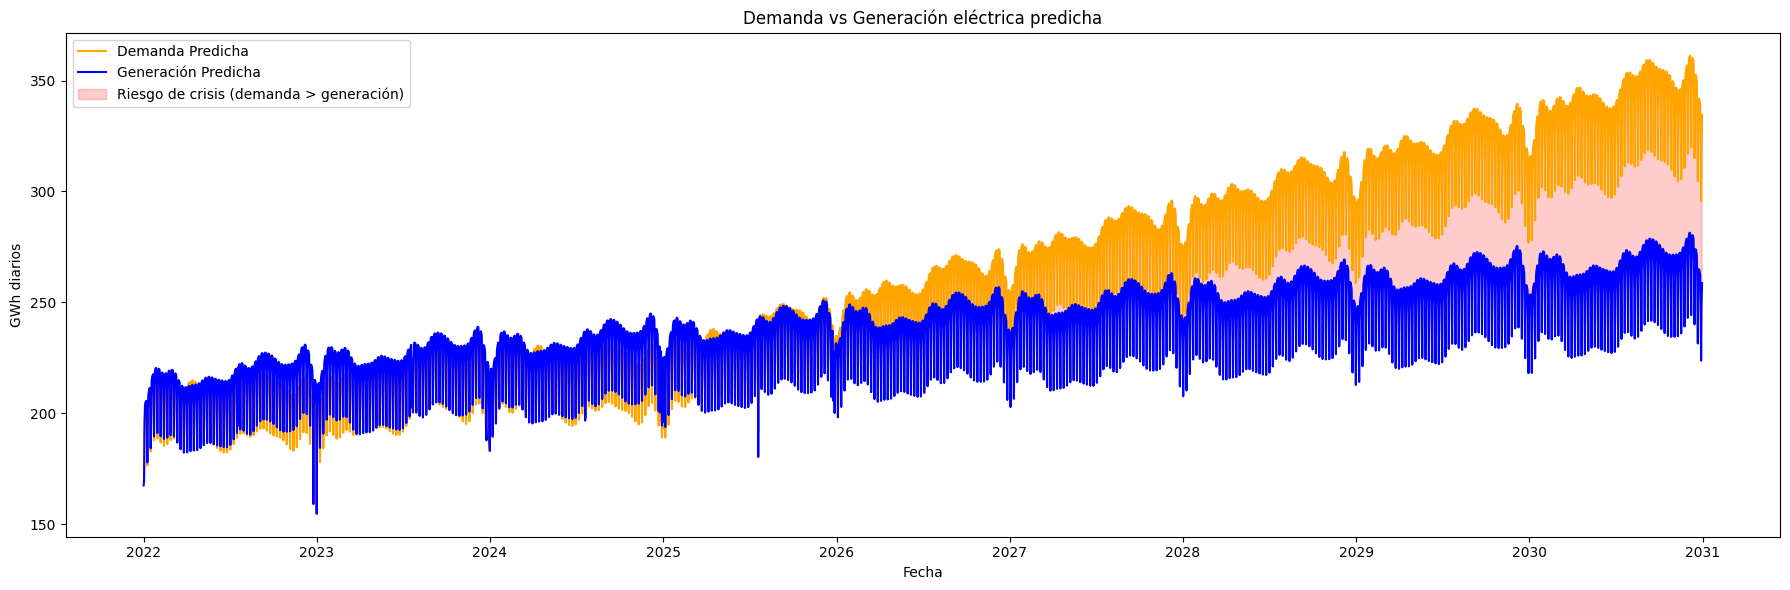

In [82]:
import matplotlib.pyplot as plt

# Unificar ambos forecasts en el mismo rango de fechas
# Ajusta los nombres si tus columnas son diferentes
df_comparativo = forecast_demanda[['ds', 'yhat']].rename(columns={'yhat': 'Demanda'})
df_comparativo = df_comparativo.merge(
    forecast_generacion[['ds', 'yhat']].rename(columns={'yhat': 'Generacion'}),
    on='ds', how='inner'
)

# Gráfico combinado
plt.figure(figsize=(18, 6))
plt.plot(df_comparativo['ds'], df_comparativo['Demanda'], color='orange', label='Demanda Predicha')
plt.plot(df_comparativo['ds'], df_comparativo['Generacion'], color='blue', label='Generación Predicha')
plt.fill_between(df_comparativo['ds'], df_comparativo['Demanda'], df_comparativo['Generacion'],
                 where=(df_comparativo['Demanda'] > df_comparativo['Generacion']),
                 color='red', alpha=0.2, label='Riesgo de crisis (demanda > generación)')
plt.title('Demanda vs Generación eléctrica predicha')
plt.xlabel('Fecha')
plt.ylabel('GWh diarios')
plt.legend()
plt.tight_layout()
plt.show()


guardar fechas previstas de crisis

In [83]:
import pandas as pd

# Suponiendo que df_comparativo ya existe con las columnas 'ds', 'Demanda', 'Generacion'
df_riesgo = df_comparativo[df_comparativo['Demanda'] > df_comparativo['Generacion']]

# Guardar en archivo CSV para análisis
df_riesgo[['ds', 'Demanda', 'Generacion']].to_csv('fechas_riesgo_crisis_energetica.csv', index=False)

print(f"Se identificaron {len(df_riesgo)} fechas probables de riesgo energético.")
print("Archivo guardado como 'fechas_riesgo_crisis_energetica.csv'.")


Se identificaron 2123 fechas probables de riesgo energético.
Archivo guardado como 'fechas_riesgo_crisis_energetica.csv'.


## Validación de conclusiones
- Según la Unidad de Planeación Minero Energética (UPME), la demanda eléctrica en Colombia crecerá en promedio 2,38% anual hasta 2038, lo que pone en tensión la infraestructura existente y podría generar un déficit estructural de energía a partir de 2027 si no se realizan nuevas inversiones en generación.
- A la fecha, Colombia debería agregar entre 3.000 y 4.000 MW de capacidad firme anual para satisfacer el crecimiento de la demanda, pero actualmente solo se está alcanzando cerca del 30% de ese objetivo.
- El potencial de crecimiento de energías renovables como la solar y eólica es significativo. En los últimos tres años, la capacidad solar en operación comercial ha crecido hasta un 187%, impulsada por políticas nacionales y el Plan Nacional de Desarrollo (PND).
- Ya se han adjudicado proyectos por más de 4.500 MW en fuentes no convencionales de energía renovable (FNCER).
- La meta oficial del país es duplicar la capacidad instalada en energías renovables para 2030 y alcanzar al menos 6 GW para 2026.
- Sin embargo, existen dificultades estructurales, incluyendo retrasos en licenciamiento ambiental, consultas previas, y limitaciones en infraestructura de transmisión, que frenan la entrada de nuevos proyectos, especialmente eólicos y solares.
## Factores de variación del crecimiento de la generación renovable
- El crecimiento real de la capacidad instalada en renovables depende de factores como:
- Agilidad regulatoria y administrativa en la aprobación de proyectos.
- Inversiones en infraestructura de transmisión eléctrica y sistemas de almacenamiento.
- Adopción masiva de generación distribuida (paneles solares residenciales e industriales).
- Estabilidad y atractivo de los esquemas de contratos de compra de energía (PPA).
- Políticas de incentivo a autogeneración y comunidades energéticas.
- En contextos de alta penetración renovable, la producción de energía puede no coincidir con los picos de consumo diario, exigiendo una gestión eficiente de los excedentes (baterías, sistemas de almacenamiento)

## Informe sobre proyecciones y factores de crecimiento de la generación eléctrica en Colombia (2025)
		
La demanda eléctrica en Colombia aumentará en promedio 2,38% anual en los próximos años, presionando la infraestructura actual y exigiendo inversiones para evitar déficit a partir de 2027. Aunque la capacidad instalada de energía renovable (solar y eólica) está creciendo rápidamente y existen metas de duplicación para 2030, la velocidad real del crecimiento depende de factores regulatorios, de infraestructura y financieros. Los retrasos en licenciamiento ambiental, limitaciones en transmisión eléctrica y la necesidad de facilitar la autogeneración y comunidades energéticas pueden ralentizar la expansión. Si bien Colombia ha avanzado en renovables (más de 4.500 MW adjudicados y el 14% de la matriz ya renovable), mantener la sostenibilidad energética requerirá continuar promoviendo inversiones, evitar cuellos de botella, y fortalecer la gestión de almacenamiento y contratos de largo plazo para mitigar la volatilidad de precios y demanda.

Por ello, los modelos de proyección de demanda y generación deben considerar las incertidumbres y la variabilidad de crecimiento en energías renovables, sobre todo en la expansión de paneles solares y plantas eólicas, además del ritmo de adopción y factores socioeconómicos.

## Fuentes:
- UPME (Unidad de Planeación Minero Energética): Proyecciones oficiales de demanda y generación.
- Atlas Renewable Energy: Perspectivas y tendencias del sector energético colombiano.
- El Colombiano: Entrevista y análisis sobre el crecimiento y déficit del sector eléctrico.
- Caracol Radio: Informe sobre déficit energético proyectado para 2027.
- SITTCA (Sistema de Información Técnica y Comercial de Colombia): Análisis de impulso renovable y cifras recientes.
- DNP (Departamento Nacional de Planeación): Reportes y proyecciones de energía renovable.
- El Universal: Artículo sobre riesgos de desabastecimiento energético para 2026.
- SER Colombia: Documento oficial sobre expansión de fuentes no convencionales de energía renovable (FNCER).
- Invest in Colombia: Datos sobre adjudicación y crecimiento en proyectos renovables.
- SEI (Stockholm Environment Institute): Estudios sobre energía solar, eólica y comunidades energéticas en Colombia.
- Climatetracker Latinoamérica: Análisis de los desafíos y oportunidades de las renovables frente al desabastecimiento